# Antutu benchmark on Android

The goal of this experiment is to run benchmarks on a hikey960 board running Android with an EAS kernel and collect results. The analysis phase will consist in comparing EAS with other schedulers, that is comparing *sched* governor with:

    - interactive
    - performance
    - sched
    
The benchmark we will be using is ***Antutu 3Dbench*** (http://www.antutu.com/en). You will need to **manually install** the app on the Android device in order to run this Notebook.


In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2017-09-06 09:59:03,768 INFO    : root         : Using LISA logging configuration:
2017-09-06 09:59:03,769 INFO    : root         :   /home/lisa/lisa-github/logging.conf


In [2]:
%pylab inline

import copy
import os
from time import sleep
from subprocess import Popen
import pandas as pd

# Support to access the remote target
import devlib
from env import TestEnv

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

Populating the interactive namespace from numpy and matplotlib


## Test environment setup

For more details on this please check out **examples/utils/testenv_example.ipynb**.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in `my_target_conf`. Run `adb devices` on your host to get the ID. Also, you have to specify the path to your android sdk in ANDROID_HOME.

In [3]:
# Setup a target configuration
my_target_conf = {
    
#     # Target platform and board
#     "platform"    : 'android',

#     # Add target support
#     "board" : 'pixel',
    
#     # Device ID
#     "device" : "HT6670300102",
    
#     "ANDROID_HOME" : "/home/vagrant/lisa/tools/android-sdk-linux/",
    
    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : "/home/lisa/android-sdk",
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
            'ip_address'     : '10.169.36.36',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
            "Device1" : 1, # iio:device0
        }
    },
    # Define devlib modules to load
    "modules"     : [
        'cpufreq'       # enable CPUFreq support
    ],
}

In [4]:
my_tests_conf = {

    # Folder where all the results will be collected
    "results_dir" : "Android_Antutu",

    # Platform configurations to test
    "confs" : [
        {
            "tag"            : "pcmark",
            "flags"          : "ftrace",           # Enable FTrace events
            "sched_features" : "ENERGY_AWARE",     # enable EAS
        },
    ],
}

In [5]:
# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration   (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

2017-09-06 09:59:08,248 INFO    : TestEnv      : Using base path: /home/lisa/lisa-github
2017-09-06 09:59:08,250 INFO    : TestEnv      : Loading custom (inline) target configuration
2017-09-06 09:59:08,251 INFO    : TestEnv      : Loading custom (inline) test configuration
2017-09-06 09:59:08,252 WARNING : TestEnv      : Wipe previous contents of the results folder:
2017-09-06 09:59:08,253 WARNING : TestEnv      :    /home/lisa/lisa-github/results/Android_Antutu
2017-09-06 09:59:08,254 INFO    : TestEnv      : External tools using:
2017-09-06 09:59:08,255 INFO    : TestEnv      :    ANDROID_HOME: /home/lisa/android-sdk
2017-09-06 09:59:08,256 INFO    : TestEnv      :    CATAPULT_HOME: /home/lisa/lisa-github/tools/catapult
2017-09-06 09:59:08,257 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq']
2017-09-06 09:59:08,258 INFO    : TestEnv      : Connecting Android target [0123456789ABCDEF]
2017-09-06 09:59:08,259 INFO    : TestEnv      : Connection settings:
2

## Support Functions

This set of support functions will help us running the benchmark using different CPUFreq governors.

In [6]:
def set_performance():
    target.cpufreq.set_all_governors('performance')

def set_powersave():
    target.cpufreq.set_all_governors('powersave')

def set_interactive():
    target.cpufreq.set_all_governors('interactive')

def set_sched():
    target.cpufreq.set_all_governors('sched')

def set_ondemand():
    target.cpufreq.set_all_governors('ondemand')
    
    for cpu in target.list_online_cpus():
        tunables = target.cpufreq.get_governor_tunables(cpu)
        target.cpufreq.set_governor_tunables(
            cpu,
            'ondemand',
            **{'sampling_rate' : tunables['sampling_rate_min']}
        )

In [7]:
# CPUFreq configurations to test
confs = {
    'performance' : {
        'label' : 'prf',
        'set' :  set_performance,
    },
    #'powersave' : {
    #    'label' : 'pws',
    #    'set' :  set_powersave,
    #},
     'interactive' : {
         'label' : 'int',
         'set' :  set_interactive,
     },
    'sched' : {
       'label' : 'sch',
       'set' :  set_sched,
    },
    #'ondemand' : {
    #    'label' : 'odm',
    #    'set' :  set_ondemand,
    #}
}

# The set of results for each comparison test
results = {}

In [8]:
#Check if PCMark si available on the device

def check_packages(pkgname):
    try:
        output = target.execute('pm list packages -f | grep -i {}'.format(pkgname))
    except Exception:
        raise RuntimeError('Package: [{}] not availabe on target'.format(pkgname))

# Check for specified PKG name being available on target
check_packages('com.antutu.ABenchMark')

In [9]:
from android import Screen

target.execute('am force-stop {}'.format("com.antutu.ABenchMark"))
target.execute('input keyevent 4')
Screen.set_orientation(target, auto=False, portrait=True)
Screen.set_brightness(target, auto=False, percent=0)
target.cpufreq.set_all_governors('interactive')

# Start PCMark on the target device
#target.execute('monkey --pct-syskeys 0 -p com.antutu.ABenchMark -c android.intent.category.LAUNCHER 1')
# Wait few seconds to make sure the app is loaded
# Screen.set_orientation(target, auto=False, portrait=True)
#sleep(10)
#target.execute('input tap 961 202')
# Wait few seconds to make sure the app is loaded
# sleep(5)
    

# Run performance workload (assume screen is vertical)


2017-09-06 09:59:33,791 INFO    : Screen       : Force manual orientation
2017-09-06 09:59:33,793 INFO    : Screen       : Set orientation: PORTRAIT
2017-09-06 09:59:35,042 INFO    : Screen       : Set brightness: 0%


''

In [10]:
# Function that helps run a Antutu experiment
from android import Screen

def benchmark_run(exp_dir):
    # Unlock device screen (assume no password required)
    target.execute('am force-stop {}'.format("com.antutu.ABenchMark"))
    target.execute('input keyevent 82')
    Screen.set_brightness(target, auto=False, percent=0)

    # Start PCMark on the target device
    target.execute('monkey --pct-syskeys 0 -p com.antutu.ABenchMark  1')
#     Screen.set_orientation(target, auto=False, portrait=True)

    # Wait few seconds to make sure the app is loaded
    sleep(5)
    
    # Flush entire log
    target.clear_logcat()
    target.execute('input tap 860 1000')
    sleep(1)
    Screen.set_orientation(target, auto=False, portrait=True)
    # Run performance workload (assume screen is vertical)
    target.execute('input tap 960 200')
    # Wait for completion (10 minutes in total) and collect log
#     log_file = os.path.join(exp_dir, 'log.txt')
    # Wait 5 minutes
    sleep(400)
    # Start collecting the log
#     with open(log_file, 'w') as log:
#         logcat = Popen(['adb logcat', 'com.antutu.ABenchMark.VirtualMachineState:*', '*:S'],
#                        stdout=log,
#                        shell=True)
#         # Wait additional two minutes for benchmark to complete
#         sleep(300)

#         # Terminate logcat
#         logcat.kill()

#     # Get scores from logcat
#     score_file = os.path.join(exp_dir, 'score.txt')
#     os.popen('grep -o ".*_SCORE .*" {} | sed "s/ = / /g" | sort -u > {}'.format(log_file, score_file))
    
    # Close application
    target.execute('am force-stop com.antutu.ABenchMark')
    
  

In [11]:
# Function that helps run PCMark for different governors

def experiment(governor, exp_dir):
    os.system('mkdir -p {}'.format(exp_dir));

    logging.info('------------------------')
    logging.info('Run workload using %s governor', governor)
    confs[governor]['set']()

    ### Run the benchmark ###
    benchmark_run(exp_dir)
    
    # return all the experiment data
    return {
        'dir'        : exp_dir,
    }

## Run PCMark and collect scores

In [13]:
# Run the benchmark in all the configured governors
for governor in confs:
    test_dir = os.path.join(te.res_dir, governor)
    res = experiment(governor, test_dir)
    print governor

2017-09-06 10:00:54,690 INFO    : root         : ------------------------
2017-09-06 10:00:54,692 INFO    : root         : Run workload using performance governor
2017-09-06 10:01:07,035 INFO    : Screen       : Set brightness: 0%
2017-09-06 10:01:13,925 INFO    : Screen       : Force manual orientation
2017-09-06 10:01:13,927 INFO    : Screen       : Set orientation: PORTRAIT


KeyboardInterrupt: 

After running the benchmark for the specified governors we can show and plot the scores:

In [21]:
# Create results DataFrame
data = {}
data['sched'] = {}
data['sched']['total'] = 102427
data['sched']['3D'] = 24634
data['sched']['UX'] = 37816
data['sched']['CPU'] = 30584
data['sched']['RAM'] = 9393

data['performance'] = {}
data['performance']['total'] = 98792
data['performance']['3D'] = 22808
data['performance']['UX'] = 38565
data['performance']['CPU'] = 28936
data['performance']['RAM'] = 8483

data['interactive'] = {}
data['interactive']['total'] = 96260
data['interactive']['3D'] = 21721
data['interactive']['UX'] = 35607
data['interactive']['CPU'] = 30439
data['interactive']['RAM'] = 8493

df = pd.DataFrame.from_dict(data)
df

,interactive,performance,sched
3D,21721,22808,24634
CPU,30439,28936,30584
RAM,8493,8483,9393
UX,35607,38565,37816
total,96260,98792,102427


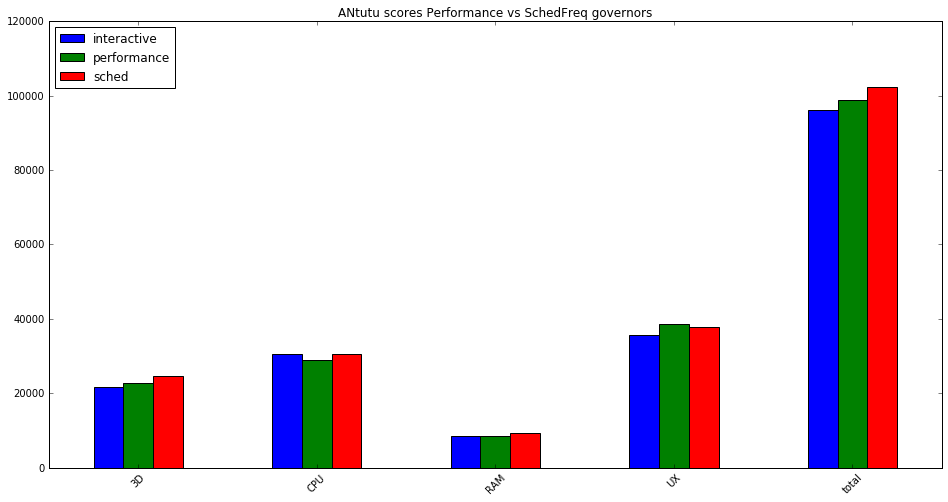

In [22]:
df.plot(kind='bar', rot=45, figsize=(16,8),
        title='ANtutu scores Performance vs SchedFreq governors');